In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import matplotlib.pyplot as plt

# Callbacks

## 1. Callbacks as GUI events

In [5]:
import ipywidgets as widgets

```
The button widget is used to handle mouse clicks.
The "on_click()" method of the Button can be used to register a callback function when clicked.
```

In [13]:
w = widgets.Button(description="ClickMe!")

In [14]:
w

Button(description='ClickMe!', style=ButtonStyle())

In [15]:
def f(o):
    print("Hey you clicked me ! :)")

In [16]:
w.on_click(f)

In [17]:
w

Button(description='ClickMe!', style=ButtonStyle())

Hey you clicked me ! :)
Hey you clicked me ! :)
Hey you clicked me ! :)
Hey you clicked me ! :)
Hey you clicked me ! :)
Hey you clicked me ! :)
Hey you clicked me ! :)


```
When callbacks are used in this way they are often called as "events"
```

## 2. Creating your own callback

In [18]:
from time import sleep

In [19]:
def slow_calculation():
    result = 0
    for i in range(5):
        result += i*i
        sleep(1)
    return result

In [20]:
slow_calculation()

30

In [21]:
def slow_calculation(cb=None):
    result = 0
    for i in range(5):
        result += i*i
        sleep(1)
        if cb:
            cb(i)
    return result


In [23]:
def show_progress(epoch):
    print(f"Awesome!! We've finished epoch {epoch}")

In [24]:
slow_calculation(cb=show_progress)

Awesome!! We've finished epoch 0
Awesome!! We've finished epoch 1
Awesome!! We've finished epoch 2
Awesome!! We've finished epoch 3
Awesome!! We've finished epoch 4


30

### Lambdas and partials

In [25]:
slow_calculation(lambda i: print(f"awesome !!!! You have finished epoch {i}"))

awesome !!!! You have finished epoch 0
awesome !!!! You have finished epoch 1
awesome !!!! You have finished epoch 2
awesome !!!! You have finished epoch 3
awesome !!!! You have finished epoch 4


30

In [32]:
def make_show_progress(greet):
    _inner = lambda i: print(f"{greet}!!!! finished epoch {i}")
    return _inner

In [33]:
slow_calculation(cb=make_show_progress(greet="Wow"))

Wow!!!! finished epoch 0
Wow!!!! finished epoch 1
Wow!!!! finished epoch 2
Wow!!!! finished epoch 3
Wow!!!! finished epoch 4


30

In [34]:
def make_show_progress(greet):
    def _inner(i):
        print(f"{greet}!! finished epoch {i}")
    return _inner

In [35]:
slow_calculation(cb=make_show_progress(greet="Superb"))

Superb!! finished epoch 0
Superb!! finished epoch 1
Superb!! finished epoch 2
Superb!! finished epoch 3
Superb!! finished epoch 4


30

In [36]:
from functools import partial

In [37]:
def show_progress(greet, epoch):
    print(f"{greet}!!! finished epoch {epoch}")

In [39]:
slow_calculation(cb=partial(show_progress, "Superb"))

Superb!!! finished epoch 0
Superb!!! finished epoch 1
Superb!!! finished epoch 2
Superb!!! finished epoch 3
Superb!!! finished epoch 4


30

In [45]:
a = partial(show_progress, "zzz")
a(20)

zzz!!! finished epoch 20


## Multiple callback functions: `*args` and `**kwargs`

In [46]:
def f(*args, **kwargs):
    print(f"args={args}, kwargs={kwargs}")

In [47]:
f(3, "a", name="flash", work="save it")

args=(3, 'a'), kwargs={'name': 'flash', 'work': 'save it'}


In [53]:
def slow_calculation(cb=None):
    result = 0
    for i in range(5):
        if cb:
            cb.before_calc(i)
        result += i*i
        sleep(1)
        if cb:
            cb.after_calc(i, val=result)
    return result

In [69]:
class PrintStepCallback():
    def __init__(self): pass
    def before_calc(self, *args, **kwargs):
        print(f"About to start.")
    def after_calc(self, *args, **kwargs):
        print(f"Done Step")

In [55]:
slow_calculation(cb=PrintStepCallback())

About to start.
Done Step
About to start.
Done Step
About to start.
Done Step
About to start.
Done Step
About to start.
Done Step


30

In [70]:
class PrintStatusCallback():
    def __init_(self):
        pass
    def before_calc(self, epoch, **kwargs):
        print(f"About to start epoch {epoch}")
    def after_calc(self, epoch, val, **kwargs):
        print(f"After epoch {epoch}: val={val}")


In [71]:
slow_calculation(cb=PrintStatusCallback())

About to start epoch 0
After epoch 0: val=0
About to start epoch 1
After epoch 1: val=1
About to start epoch 2
After epoch 2: val=5
About to start epoch 3
After epoch 3: val=14
About to start epoch 4
After epoch 4: val=30


30

## Modifying Behaviour

In [83]:
def slow_calculation(cb=None):
    result = 0
    for i in range(5):
        if cb and hasattr(cb, "before_calc"):
            cb.before_calc(i)
        result += i*i
        sleep(1)
        if cb and hasattr(cb, "after_calc"):
            if cb.after_calc(i, result):
                print(f"Stopping early")
                break
    return result
                

In [84]:
class PrintAfterCallback():
    def __init__(self):
        pass
    def after_calc(self, epoch, val):
        print(f"After epoch={epoch}: val={val}")
        if val > 10:
            return True        
        

In [85]:
slow_calculation(cb=PrintAfterCallback())

After epoch=0: val=0
After epoch=1: val=1
After epoch=2: val=5
After epoch=3: val=14
Stopping early


14

In [102]:
class SlowCalculator():
    def __init__(self, cb=None):
        self.cb = cb
        self.result = 0
        
    def callback(self, cb_name, *args):
        if not self.cb:
            return
        cb = getattr(self.cb, cb_name, None)
        if cb:
            return cb(self, *args)
        
    def calc(self):
        for i in range(5):
            self.callback("before_calc", i)
            self.result += i*i
            sleep(1)
            if self.callback("after_calc", i):
                print("Stopping Early")
                break
        

In [103]:
class ModifyingCallback():
    def after_calc(self, calc, epoch):
        print(f"After epoch {epoch}: val={calc.result}")
        if calc.result > 10:
            return True              
        

In [104]:
calculator = SlowCalculator(cb=ModifyingCallback())

In [105]:
calculator.calc()

After epoch 0: val=0
After epoch 1: val=1
After epoch 2: val=5
After epoch 3: val=14
Stopping Early


In [106]:
calculator.result

14

# `__dunder__` thingies:

```
Anything that looks like __this__ is, in some way, special. 
Python or some library, can define some functions that they call at certain documented times.
For instance, when a class is setting up a new object, Python will call __init__.
These are defined as part of the Python "data model"

For example, 
1. if python sees "+"  operator then it will call the special method "__add__"
2. if you try to display an object it will call "__repr__"
```

In [107]:
class SloppyAdder():
    def __init__(self, o):
        self.o = o
    def __add__(self, b):
        return SloppyAdder(self.o + b.o + 0.01)
    def __repr__(self):
        return str(self.o)    
        

In [108]:
a = SloppyAdder(1)
b = SloppyAdder(2)
a+b

3.01

#### Special methods to know in Python:
```
 1. __getitem__
 2. __getattr__
 3. __setattr__
 4. __del__
 5. __init__
 6. __new__
 7. __enter__
 8. __exit__
 9. __len__
10. __repr__
11. __str__

```

# Variance & stuff

```
Variance is the average of how far each datapoint is from the mean
```

In [120]:
t = torch.tensor([1, 2, 3, 4, 5, 7, 8, 59.])

In [121]:
m = t.mean()
m

tensor(11.1250)

In [122]:
var = (t-m).mean()
var

tensor(0.)

```
This above definition of var is expected to ALWAYS give a value of ZERO; b'coz that's how mean is defined.

Proof:

mean = (sum(X))/N
mean - mean = (sum(X))/N - mean
          0 = (sum(X-mean))/N
          0 = variance

So, the above definition of variance will always be ZERO.
This happened becasue the definition of positives and negatives cancel out.
We can fix this in two ways:
1. using absolute values : abs(*)
2. using squared values & then square-root : .pow(2) & then .sqrt()
```

In [123]:
### method-1: Taking absolute values
v1 = (t-m).abs().mean()
v1

tensor(11.9688)

In [124]:
### method-2: Taking square and the taking square-root to maintain the scale
v2_sq = (t-m).pow(2).mean()
print(v2_sq)
v2 = (t-m).pow(2).mean().sqrt()
v2

tensor(332.3594)


tensor(18.2307)

In [119]:
### Above we can clearly see that the scale of v2_sq is very different than v2 or v1

```
But the value sof v1 & v2 are still very differnt; why?

Note that in our data "t" we have an outlier "59".
So when we take the square in calculating "v2_sq", the impact of outliers become magnified...i.e bigger becomes much bigger and smaller becomes muich smaller; hence impacting the overall value of "v2"

But this effect is not seen much in calculating "v1".

We refer to these two (v1 & v2) with separate names:
1. v1: MEAN ABSOLUTE DEVIATION
2. v2: STANDARD DEVIATION
3. v2_sq: VARIANCE

There hasn't been much use of v1 in traditional maths, due to bad behaviour of abs() function in derivates & stuffs..... But we can use it in computaional maths due to computer's ability.

```

#### Important fact about variance:

In [125]:
(t-m).pow(2).mean(), ((t*t).mean() - (m*m))

(tensor(332.3594), tensor(332.3594))

```
The above cell shows results from probability theory:

Def#1: Variance(X) = (X-m).pow(2).mean()
Def#2: Variance(X) = (Expectation(X.pow(2)) - (Expectation(X)).pow(2)

In Def#1, we have to go through the whole dataset twice (once to find (X-m) and the to find the square)
While in Def#2, we have to track only two values: 
    a. Sum of the squares of data i.e calculating the 1st part
    b. Sum of the data i.e calculating the 2nd part
    
So, in essence, Def#2 is much easier to work with
```

# Covariance & Correlation

```
Def#:
Covariance(X, Y) = Expectation((X-Expecatation(X)) * (Y-Expectation(Y))
                 = E[(X-E[X]) * (Y-E[Y])]                                   ----- eq(1)
                 = E[XY] - E[X]*E[Y]                                        ----- eq(2)

```

In [126]:
t

tensor([ 1.,  2.,  3.,  4.,  5.,  7.,  8., 59.])

In [127]:
### "u" is twice "t"; plus a little bit of randomness

u = t*2
u *= torch.randn_like(t)/10 + 0.95

In [128]:
u

tensor([  1.7600,   4.0610,   5.6736,   8.2653,   7.5210,  13.5107,  16.6691,
        108.1631])

In [131]:
t*2

tensor([  2.,   4.,   6.,   8.,  10.,  14.,  16., 118.])

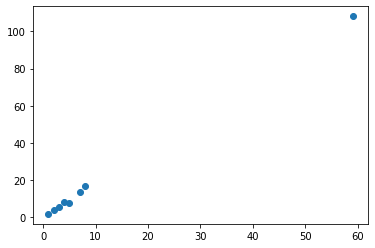

In [130]:
plt.scatter(t, u)

In [137]:
prod = (t-t.mean())*(u-u.mean())
prod

tensor([ 191.7975,  151.8577,  122.1134,   88.6186,   80.7398,   29.6683,
          12.6058, 4187.1538])

In [142]:
cov_t_u = prod.mean()
cov_t_u

tensor(608.0693)

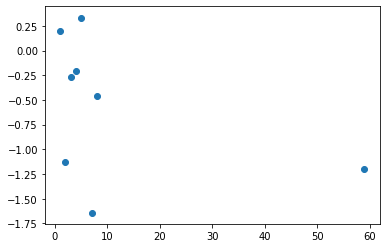

In [143]:
v = torch.randn_like(t)
plt.scatter(t, v)

In [144]:
cov_2_t_v = ((t-t.mean())*(v-v.mean())).mean()
cov_2_t_v

tensor(-4.9020)

```
Defn#:

Covariance is also defined as:

Covariance(X,Y) = Expectation(X*Y) - Expectation(X)*Expectation(Y)
                = E[XY] - E[X]*E[Y]
                
```

In [145]:
cov_3_t_v = (t*v).mean() - t.mean()*v.mean()
cov_3_t_v

tensor(-4.9020)

In [147]:
torch.allclose(cov_2_t_v, cov_3_t_v)

True

### Pearson Correlation Coefficient:
```
PearsonCorrelation_coeff(X,Y) = Covariance(X,Y) / (std(X)*std(Y))

corr_pearson_coeff = cov(X,Y) / (X.std() * Y.std())

```

In [148]:
t

tensor([ 1.,  2.,  3.,  4.,  5.,  7.,  8., 59.])

In [150]:
v

tensor([ 0.1943, -1.1334, -0.2716, -0.2064,  0.3335, -1.6407, -0.4636, -1.1998])

In [151]:
corr_pearson_coeff_t_v = ((t*v).mean() - t.mean()*v.mean()) / (t.std()*v.std())
corr_pearson_coeff_t_v

tensor(-0.3562)